In [1]:
%load_ext autoreload
%autoreload 2

from gpu import set_gpu
import numpy as np
import os
import adapt.utils.data_utils as prd
import adapt.loop as lp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import adapt.ml.dl_subclass as dl
import copy as cp

set_gpu()

Using TensorFlow backend.


Num GPUs Available:  1


In [2]:
path = 'C:/Users/yteh/Documents/work/necal/home data/TR58/DATA/MAT/'
all_files = os.listdir(path)
train_file = all_files[1]
train_file2 = all_files[1]
ft= 'feat'

In [3]:
all_files = np.delete(all_files,0)

In [4]:
train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
train_data = train_data[:,:8,:]

train_dof = np.unique(train_params[:,2])
key = np.empty(train_dof.shape)
for i in range(len(train_dof)):
    key[i] = train_params[np.argmax(train_params[:,2] == train_dof[i]),0]

In [4]:
train_data2, train_params2 = prd.load_caps_train(path + train_file2 + '/traindata.mat')
train_data2 = train_data2[:,:8,:]
train_data = np.vstack((train_data,train_data2))
train_params = np.vstack((train_params,train_params2))

In [5]:
# Prep initial training data
ep = 30
n_dof = len(train_dof)

trainmlp_0, traincnn_0, y_train_0, x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b = False, batch_size=64,ft=ft, noise=True)
y_test_0, x_test_mlp_0, x_test_cnn_0, x_lda_0, y_lda_0 = prd.prep_test_caps(train_data, train_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft)


In [6]:
# Initial training
mlp, cnn, w, c = lp.train_models(traincnn_0, trainmlp_0, x_train_lda_0, y_train_lda_0, n_dof, ep=30)
mlp_0 = mlp.get_weights()
cnn_0 = cnn.get_weights()
w_0 = cp.deepcopy(w)
c_0 = cp.deepcopy(c)

In [7]:
# Test all controllers without recalibration or adaptation
acc = np.empty((len(all_files),5))

for i in range(0,len(all_files)):
    # load data
    test_file = all_files[i]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:]
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft)
    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c])
    print ('Set: ' + test_file, f'CNN Accuracy: {acc[i,2]:.2f},', f'MLP Accuracy: {acc[i,1]:.2f},', f'LDA Accuracy: {acc[i,0]:.2f}')

Set: 20170730_054913 CNN Accuracy: 98.86, MLP Accuracy: 90.56, LDA Accuracy: 79.94
Set: 20170730_055812 CNN Accuracy: 75.81, MLP Accuracy: 68.86, LDA Accuracy: 69.62
Set: 20170730_060537 CNN Accuracy: 75.35, MLP Accuracy: 70.38, LDA Accuracy: 69.49
Set: 20170730_123937 CNN Accuracy: 74.17, MLP Accuracy: 66.84, LDA Accuracy: 62.62
Set: 20170731_123147 CNN Accuracy: 69.83, MLP Accuracy: 66.67, LDA Accuracy: 57.90
Set: 20170801_053500 CNN Accuracy: 69.66, MLP Accuracy: 63.46, LDA Accuracy: 58.79
Set: 20170801_054938 CNN Accuracy: 64.26, MLP Accuracy: 62.20, LDA Accuracy: 57.82
Set: 20170801_065547 CNN Accuracy: 71.09, MLP Accuracy: 64.18, LDA Accuracy: 47.16
Set: 20170802_050945 CNN Accuracy: 71.09, MLP Accuracy: 68.86, LDA Accuracy: 63.76
Set: 20170802_051732 CNN Accuracy: 69.53, MLP Accuracy: 68.31, LDA Accuracy: 70.71
Set: 20170802_052140 CNN Accuracy: 72.36, MLP Accuracy: 64.60, LDA Accuracy: 57.02
Set: 20170807_153152 CNN Accuracy: 63.89, MLP Accuracy: 66.46, LDA Accuracy: 68.90
Set:

In [8]:
# Test all controllers with ewc
ep = 30
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
ewc_acc = np.empty((len(all_files),5))
ewc_acc[:] = np.nan
rec_acc = np.empty((len(all_files),5))
rec_acc[:] = np.nan

n_dof = len(train_dof)

cnn.set_weights(cnn_0)
mlp.set_weights(mlp_0)

ewc_cnn = dl.EWC(mod='CNN')
ewc_cnn(x_train_cnn_0[:1,...])
loss, fish_loss = lp.train_task(ewc_cnn, ep, 1, x_train_cnn_0,y_train_0, [x_test_cnn_0],[y_test_0], lams=[0])
x_test_ewc_cnn_0 = cp.deepcopy(x_test_cnn_0)
y_test_ewc_0 = cp.deepcopy(y_test_0)
x_test_ewc_cnn = cp.deepcopy(x_test_cnn_0)
y_test_ewc = cp.deepcopy(y_test_0)

ewc = dl.EWC()
ewc(x_train_mlp_0[:1,...])
loss, fish_loss = lp.train_task(ewc, ep, 1, x_train_mlp_0,y_train_0, [x_test_mlp_0],[y_test_0], lams=[0])
x_test_ewc_0 = cp.deepcopy(x_test_mlp_0)
x_test_ewc = cp.deepcopy(x_test_mlp_0)

ewc_acc[0,:] = lp.test_models(x_test_cnn_0, x_test_mlp_0, x_lda_0, y_test_0, y_lda_0, cnn, mlp, [w_0, c_0], ewc, ewc_cnn)

for i in range(1,len(all_files)-1,2):
    # load recalibration data
    ewc_file = all_files[i]
    ewc_data, ewc_params = prd.load_caps_train(path + ewc_file + '/traindata.mat')
    ewc_data = ewc_data[:,:8,:]

    ewc_cnn.compute_fisher(x_test_ewc_cnn, y_test_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc_cnn.star()

    ewc.compute_fisher(x_test_ewc, y_test_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc.star()

    # check class labels
    ewc_data, ewc_params = lp.check_labels(ewc_data, ewc_params, train_dof, key)
    
    ewcmlp, ewccnn, y_train_ewc, x_train_ewc, x_train_ewc_cnn, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=64, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft)
    y_test_ewc, x_test_ewc, x_test_ewc_cnn, x_lda, y_lda = prd.prep_test_caps(ewc_data, ewc_params, scaler, emg_scale, num_classes=n_dof,ft=ft)

    loss, fish_loss = lp.train_task(ewc_cnn, 30, 1, x_train_ewc_cnn, y_train_ewc, [x_test_ewc_cnn_0, x_test_ewc_cnn], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
    loss, fish_loss = lp.train_task(ewc, 30, 1, x_train_ewc, y_train_ewc, [x_test_ewc_0, x_test_ewc], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
    mlp, cnn, w, c = lp.train_models(ewccnn, ewcmlp, x_train_lda, y_train_lda, n_dof, 5, mlp, cnn)
    mlp_r, cnn_r, _, _ = lp.train_models(ewccnn, ewcmlp, n_dof=n_dof, ep=30)

    # load test data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:]
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data, test_params, train_dof, key)

    ewc_acc[i,:] = lp.test_models(x_test_ewc_cnn, x_test_ewc, x_lda, y_test_ewc, y_lda, cnn, mlp, [w,c], ewc, ewc_cnn)
    rec_acc[i,:] = lp.test_models(x_test_ewc_cnn, x_test_ewc, x_lda, y_test_ewc, y_lda, cnn_r, mlp_r)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof,ft=ft)
    ewc_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w,c], ewc, ewc_cnn)
    rec_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn_r, mlp_r)

    x_test_ewc_cnn_0 = cp.deepcopy(x_test_ewc_cnn)
    x_test_ewc_0 = cp.deepcopy(x_test_ewc)
    y_test_ewc_0 = cp.deepcopy(y_test_ewc)

    print ('EWC: ' + ewc_file + ', Test: ' + test_file + ',', f'EWC CNN Accuracy: {ewc_acc[i+1,4]:.2f},', f'EWC Accuracy: {ewc_acc[i+1,3]:.2f},', f'a-CNN Accuracy: {ewc_acc[i+1,2]:.2f},', f'a-MLP Accuracy: {ewc_acc[i+1,1]:.2f},',  f'r-CNN Accuracy: {rec_acc[i+1,2]:.2f},', f'r-MLP Accuracy: {rec_acc[i+1,1]:.2f},', f'r-LDA Accuracy: {ewc_acc[i+1,0]:.2f}')

Initial val acc 0: 0.4762
Final val acc 0: 0.9751
Initial val acc 0: 0.0952
Final val acc 0: 0.9039
Initial val acc 0: 0.9751, val acc 1: 0.7311
Final val acc 0: 0.8226, val acc 1: 0.9208
Initial val acc 0: 0.9039, val acc 1: 0.6734
Final val acc 0: 0.8807, val acc 1: 0.8314
EWC: 20170730_055812, Test: 20170730_060537, EWC CNN Accuracy: 76.53, EWC Accuracy: 79.22, a-CNN Accuracy: 76.70, a-MLP Accuracy: 78.26, r-CNN Accuracy: 75.56, r-MLP Accuracy: 70.12, r-LDA Accuracy: 71.05
Initial val acc 0: 0.9208, val acc 1: 0.7042
Final val acc 0: 0.7632, val acc 1: 0.9414
Initial val acc 0: 0.8314, val acc 1: 0.7813
early stop
Final val acc 0: 0.7712, val acc 1: 0.8601
EWC: 20170730_123937, Test: 20170731_123147, EWC CNN Accuracy: 66.12, EWC Accuracy: 69.45, a-CNN Accuracy: 65.91, a-MLP Accuracy: 70.80, r-CNN Accuracy: 67.55, r-MLP Accuracy: 63.17, r-LDA Accuracy: 50.65
Initial val acc 0: 0.9414, val acc 1: 0.6490
Final val acc 0: 0.7708, val acc 1: 0.8972
Initial val acc 0: 0.8601, val acc 1: 0

In [20]:
ewc_acc[0,...] = np.nan
rec_acc[0,...] = np.nan
rlda_acc = np.empty((len(all_files),15))
rlda_acc[:] = np.nan
lda_acc = np.empty((len(all_files),15))
lda_acc[:] = np.nan
acc_all = np.hstack((acc[1:,...],ewc_acc,rec_acc))
for i in range(acc.shape[1]):
    rlda_acc[:,i] = acc[1:,i] - ewc_acc[:,0]
    rlda_acc[:,i+5] = ewc_acc[:,i] - ewc_acc[:,0]
    rlda_acc[:,i+10] = rec_acc[:,i] - ewc_acc[:,0]

    lda_acc[:,i] = acc[1:,i] - acc[1:,0]
    lda_acc[:,i+5] = ewc_acc[:,i] - acc[1:,0]
    lda_acc[:,i+10] = rec_acc[:,i] - acc[1:,0]

In [23]:
lda_i = [0, 5]
cnn_i = [2, 12, 7, 9]
mlp_i = [1, 11, 6, 8]
# cnn_i = [2, 12, 9]
# mlp_i = [1, 11, 8]
nn_i = np.vstack((mlp_i,cnn_i))

colors =  cm.get_cmap('tab20c')
c = np.empty((20,4))
for i in range(20):
    c[i,:] = colors(i*1/20)

mlp_c = np.vstack((c[8,:],c[9,:],c[10,:],c[11,:]))
cnn_c = np.vstack((c[0,:],c[1,:],c[2,:],c[3,:]))
nn_c = np.stack((mlp_c,cnn_c))
lda_c = ['ko-','ko--']
nn_m = ['o-','s-','v-','x-']

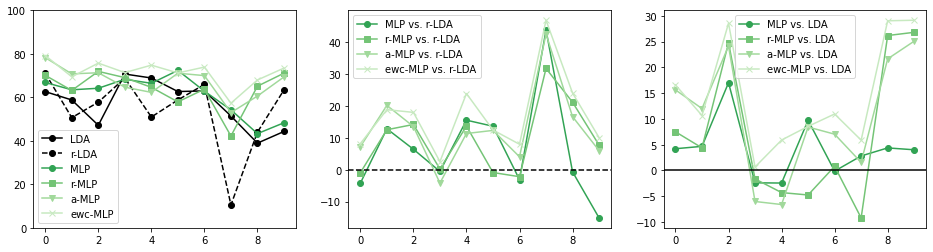

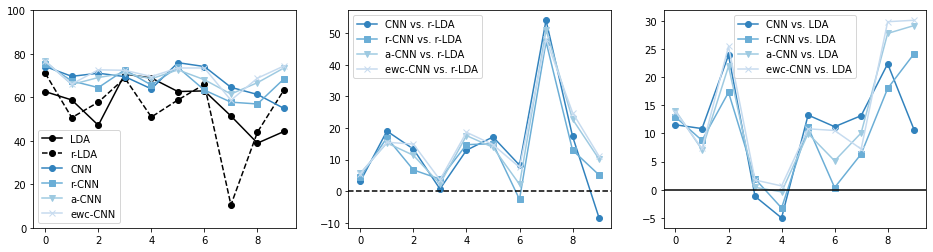

In [24]:
mask = ~np.isnan(rlda_acc)

for mod in range(nn_i.shape[0]):
    i_ = nn_i[mod,...]
    fig,ax = plt.subplots(1,3,figsize=(16,4))

    for i in range(len(lda_i)):
        ax[0].plot(acc_all[mask[:,lda_i[i]],lda_i[i]], lda_c[i])
    for i in range(len(i_)):
        ax[0].plot(acc_all[mask[:,i_[i]],i_[i]], nn_m[i], color=nn_c[mod,i,:])
        ax[1].plot(rlda_acc[mask[:,i_[i]],i_[i]], nn_m[i], color=nn_c[mod,i,:])
        ax[2].plot(lda_acc[mask[:,i_[i]],i_[i]], nn_m[i], color=nn_c[mod,i,:])

    if mod == 0:
        ax[0].legend(['LDA', 'r-LDA', 'MLP', 'r-MLP', 'a-MLP', 'ewc-MLP'])
        ax[1].legend(['MLP vs. r-LDA', 'r-MLP vs. r-LDA', 'a-MLP vs. r-LDA', 'ewc-MLP vs. r-LDA'])
        ax[2].legend(['MLP vs. LDA', 'r-MLP vs. LDA', 'a-MLP vs. LDA', 'ewc-MLP vs. LDA'])
    else:
        ax[0].legend(['LDA', 'r-LDA', 'CNN', 'r-CNN', 'a-CNN', 'ewc-CNN'])
        ax[1].legend(['CNN vs. r-LDA', 'r-CNN vs. r-LDA', 'a-CNN vs. r-LDA', 'ewc-CNN vs. r-LDA'])
        ax[2].legend(['CNN vs. LDA', 'r-CNN vs. LDA', 'a-CNN vs. LDA', 'ewc-CNN vs. LDA'])

    ax[0].set_ylim([0,100])
    ax[1].axhline(0, ls = '--',color='black')
    ax[2].axhline(0, color='black')

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
x = range(0,acc.shape[0]-2,1)
x_skip = range(0,acc.shape[0]-2,2)

for i in range(3):
    ax[0].plot(x_skip,acc[2::2,i],'o', label='_nolegend_')
    ax[0].plot(x,acc[2:,i],'-')

    if i == 0:
        ls = 's--'
    else:
        ls = 's-'
    ax[1].plot(x_skip,recal_acc[mask,i], ls)

    if i > 0:
        ax[2].plot(x_skip,adapt_acc[mask,i], 'v-')

    ax[i].set_ylim([0,100])

ax[0].legend(['LDA','MLP','CNN'])
ax[1].legend(['r-LDA','r-MLP','r-CNN'])
ax[2].legend(['a-MLP','a-CNN'])  

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
x = range(0,acc.shape[0]-2,1)
x_skip = range(0,acc.shape[0]-2,2)

for i in range(3):
    ax[0].plot(x_skip,acc[2::2,i],'o',color=col[i,:], label='_nolegend_')
    ax[0].plot(x,acc[2:,i],'-',color=col[i,:])

    if i == 0:
        ls = 's--'
    else:
        ls = 's-'
    ax[1].plot(x_skip,recal_acc[mask,i], ls,color=col[i,:])

    if i > 0:
        ax[2].plot(x_skip,adapt_acc[mask,i], 'v-',color=col[i,:])

    ax[i].set_ylim([0,100])

ax[0].legend(['LDA','MLP','CNN'])
ax[1].legend(['r-LDA','r-MLP','r-CNN'])
ax[2].legend(['a-MLP','a-CNN'])  

In [ ]:
# Test all controllers with adaptation
ep = 15
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
align_acc = np.empty((len(all_files),3))
align_acc[:] = np.nan
n_dof = len(train_dof)

for i in range(1,len(all_files)-1,2):
    # load recalibration data
    align_file = all_files[i]
    align_data, align_params = prd.load_caps_train(path + align_file + '/traindata.mat')
    align_data = align_data[:,:8,:]

    # check class labels
    align_data, align_params = lp.check_labels(align_data, align_params, train_dof, key)
    
    alignmlp, aligncnn, _, _, _, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(align_data, align_params, prop_b = False, num_classes=n_dof, batch_size=64, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft)
    mlp, cnn, mlp_ali, cnn_ali, w, c = lp.train_models(aligncnn, alignmlp, x_train_lda, y_train_lda, n_dof, ep, mlp, cnn, align=True)
    
    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:].astype('float64')
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data, test_params, train_dof, key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof,ft=ft)
    align_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c], cnn_align=cnn_ali, mlp_align=mlp_ali)

    print ('Align: ' + align_file + ', Test: ' + test_file, f', CNN Accuracy: {align_acc[i+1,2]:.2f},', f'MLP Accuracy: {align_acc[i+1,1]:.2f},', f'LDA Accuracy: {align_acc[i+1,0]:.2f}')